# ECG Classification

In this notebook we explored the PTB-XL dataset as downloaded from physionet. It helped us get some ideas on how to manipulate the data, which classes were important, and served to work on some dummy models.

However, it was later detected that the files we were using did not contain the diagnosis in the SNOMED format, which is exactly what we need. For this reason, we stopped working on this nb.

If you want to run this notebook, beware, since some sections were slightly modified and it does not actually compile in a straightforward manner.

## Original code

These first lines are an exact copy of the code in 'example_physionet.ipynb'

In [2]:
import pandas as pd
import numpy as np
import wfdb
import ast

In [3]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [4]:
path = '../data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

In [4]:
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

In [5]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [6]:
# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

## New code

In [8]:
import random

import matplotlib.pyplot as plt
import matplotlib

from sklearn.model_selection import train_test_split

In [35]:
random_state = 203129

### Visualizing ECGs

Now we begin to modify and extend on it a little. First, we make some plots to visualize the ECG.

In [9]:
# This is the order of the 12 signals for each file in the PTB-XL dataset
signals = ['I', 'II', 'III', 'AVL', 'AVR', 'AVF', 'V1', 'V2','V3','V4','V5', 'V6']

For plotting, it is more visually similar to the real ECG pictures if we standarize the limits in which each wave is portrayed. For this, it would be best to both: Set limits and allow overlapping. Nevertheless, overlapping is not as straightfowrard to code, so we just use the limits for the moment.

In [10]:
ylim_top = np.quantile(X, 0.999)
ylim_bot = np.quantile(X, 0.001)

print('top limit: ', ylim_top, ', bot limit: ', ylim_bot)

top limit:  1.719 , bot limit:  -1.858


In [11]:
def plot_ecg(waves, ylim_top=ylim_top, ylim_bot=ylim_bot, figsize=(16,20)):

    """
    Plot the 12-lead ecg. Note this function assumes we are using the standard 12 leads in the 
    following order:
    
    signals = ['I', 'II', 'III', 'AVL', 'AVR', 'AVF', 'V1', 'V2','V3','V4','V5', 'V6']
    
    Inputs:
        waves - np.array, shape=(n, 12); n is the number of simulations for each individual signal.
        ylim_top - float; sets the upper limit for every signal.
        ylim_bot - float; sets the lower limit for every signal.
    
    Possible Upgrades:
        Don't immediately assume it has 12 channels, nor the order. Instead pass both as parameters.
        The y limits by themselves are not good enough to represent a more realistic image. We could
        use some overlapping between waves.
        Maybe the patients id and the diagnostic can be added at the top.
    """
    
    fig, axs = plt.subplots(12,1,figsize=figsize, facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = -0.11)

    axs = axs.ravel()

    for channel in range(12):
        axs[channel].plot(range(len(waves[:, channel])), waves[:, channel])
        axs[channel].set_ylabel(signals[channel], fontsize=14, rotation=0, labelpad=20)
        axs[channel].set_ylim(ylim_bot, ylim_top)

NameError: name 'ylim_top' is not defined

Example of a complete 10 second ECG:

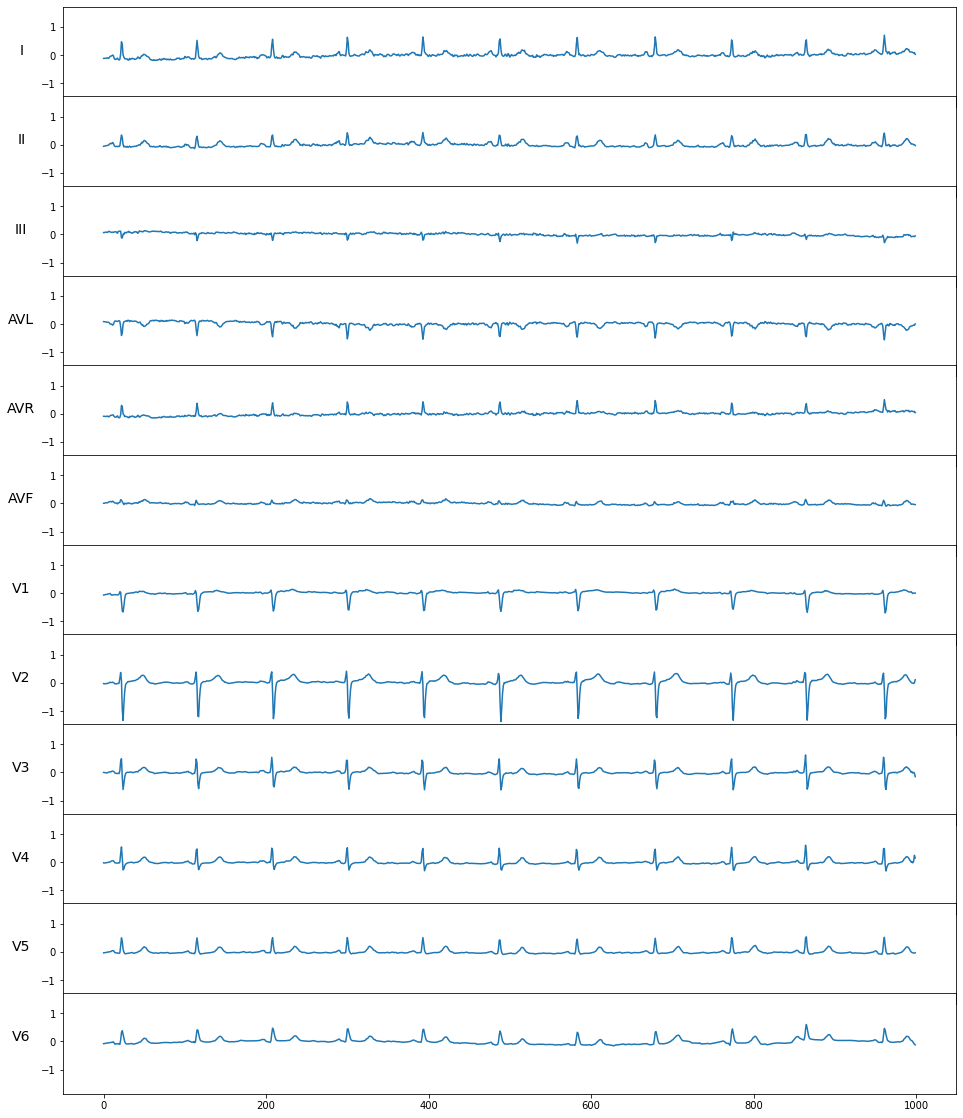

In [12]:
plot_ecg(X[0])

Example of the same ECG but cut into only 3 seconds:

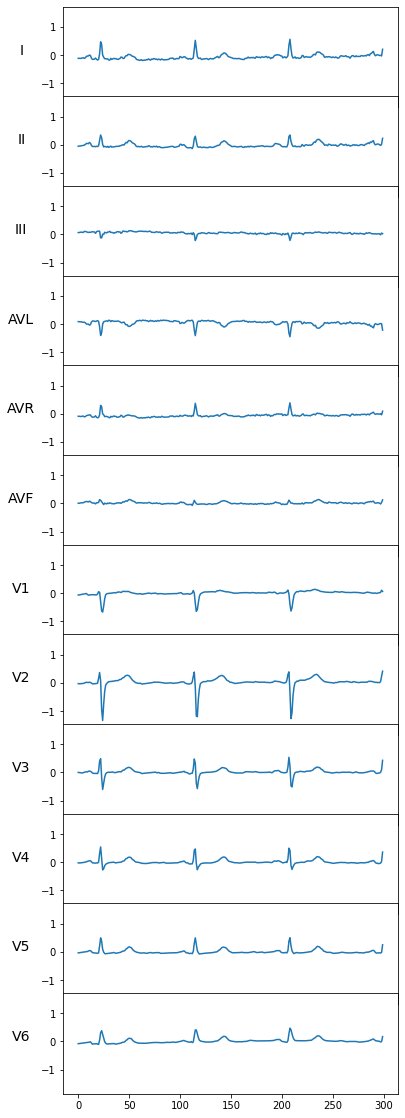

In [13]:
plot_ecg(X[0, :300], figsize=(6,20))

### Crossing files

This section serves to help us make intersection between the file **scp_statements.csv**, which contains information and the 

### EDA

First, let's observe at how the diagnosis superclasses are distributed. We can appretiate that ECGs are not neccesarily classified with only one diagnosis, but rather can have many:

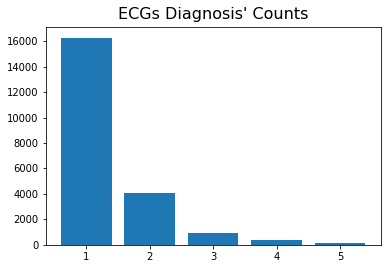

In [14]:
diag_lens = Y.diagnostic_superclass.apply(lambda x : len(x))
diag_vc = diag_lens.value_counts()
fig, ax = plt.subplots()

ax.bar(np.array(range(len(diag_vc)))+1, diag_vc)
ax.set_title("ECGs Diagnosis' Counts", fontsize=16, y = 1.01);

Among these superclasses, there are some that are of major interest: **MI** and **STTC**.

In [15]:
superclasses = set(agg_df.diagnostic_class)
superclasses

{'CD', 'HYP', 'MI', 'NORM', 'STTC'}

We create a OHE to ceheck intersections.

In [16]:
superclasses_df = pd.DataFrame(columns = superclasses)

for i in range(len(Y.diagnostic_superclass)):
    
    class_aux = pd.DataFrame(index = [0], columns = superclasses)
    
    for sc in Y.diagnostic_superclass.iloc[i]:
        class_aux.loc[0, sc] = 1
        
        
    superclasses_df = pd.concat([superclasses_df, class_aux])
    
superclasses_df = superclasses_df.fillna(0)

In [17]:
superclasses_df

,MI,HYP,STTC,NORM,CD
0,0,0,0,1,0
0,0,0,0,1,0
0,0,0,0,1,0
0,0,0,0,1,0
0,0,0,0,1,0
...,...,...,...,...,...
0,0,0,1,0,0
0,0,0,0,1,0
0,0,0,1,0,0
0,0,0,0,1,0


As we can see, there are several intersections between MI & STTC.

In [18]:
val = 'MI'
print(f'Total {val} registers:', sum(superclasses_df[val] == 1))
val = 'STTC'
print(f'Total {val} registers:', sum(superclasses_df[val] == 1))
val = 'NORM'
print(f'Total {val} registers:', sum(superclasses_df[val] == 1))

print()

val1, val2 = 'MI', 'STTC'
print(f'Total {val1} & {val2} registers:', sum((superclasses_df[val1] == 1) & (superclasses_df[val2] == 1)))
val1, val2 = 'MI', 'NORM'
print(f'Total {val1} & {val2} registers:', sum((superclasses_df[val1] == 1) & (superclasses_df[val2] == 1)))
val1, val2 = 'STTC', 'NORM'
print(f'Total {val1} & {val2} registers:', sum((superclasses_df[val1] == 1) & (superclasses_df[val2] == 1)))

Total MI registers: 5486
Total STTC registers: 5250
Total NORM registers: 9528

Total MI & STTC registers: 1345
Total MI & NORM registers: 1
Total STTC & NORM registers: 33


we will stratify based on MI, STTC and other.

In [32]:
# Copy and keep only the classes of interest
strat_df = superclasses_df.copy()
strat_df = strat_df.reset_index()
strat_df.index = strat_df.index + 1
strat_df = strat_df[['MI', 'STTC']]

# Intersection between MI & STTC
strat_df['MI&STTC'] = (strat_df['MI'] == 1) & (strat_df['STTC'] == 1)
strat_df['MI&STTC'] = strat_df['MI&STTC'].astype(int)

# Correct MI and STTC columns given an intersection
strat_df['MI'] = strat_df['MI'] - strat_df['MI&STTC']
strat_df['STTC'] = strat_df['STTC'] - strat_df['MI&STTC']

# Create the OTHER column as the complement
strat_df['OTHER'] = (strat_df['MI'] == 0) & (strat_df['STTC'] == 0) & (strat_df['MI&STTC'] == 0)
strat_df['OTHER'] = strat_df['OTHER'].astype(int)

# Add a label column 
strat_df['label'] = strat_df.idxmax(axis=1)
print(strat_df.shape)
strat_df.head()

(21837, 5)


,MI,STTC,MI&STTC,OTHER,label
1,0,0,0,1,OTHER
2,0,0,0,1,OTHER
3,0,0,0,1,OTHER
4,0,0,0,1,OTHER
5,0,0,0,1,OTHER


In [38]:
strat_df[strat_df['MI'] == 1].sample(5, random_state=random_state)

,MI,STTC,MI&STTC,OTHER,label
2269,1,0,0,0,MI
13209,1,0,0,0,MI
14458,1,0,0,0,MI
12260,1,0,0,0,MI
5153,1,0,0,0,MI


### Training classifier

We will now try to predict the diagnosis superclass based on the 12 leads.

#### Improvements

    1. Still no standard scaler
    2. There must be some tweaks to the CNN we can do.
        a. Check how to not lose info given strides.
        b. Droput, L1 Reg, different activations, Batch Norm, etc.
    3. Try other arquitectures

#### Data Preprocessing

We train a very simple classifer. We will use a CNN considering we have n * 12 matrices, where n is the sample size for each signal. In order to make some quick progress, we will cut the original size of n = 1000 to n' = 300, that is, we only take 3 second leads.

In [18]:
X_3sec = X[:,:300,:]

In [21]:
random.seed(1234)

val_size = 0.2
test_size = 0.2

# Train and test
train_set_x, test_set_x = train_test_split(X_3sec, stratify=strat_df['label'], test_size=test_size, random_state=random_state)
train_set_y, test_set_y = train_test_split(Y, stratify=strat_df['label'], test_size=test_size, random_state=random_state)
# Train and val
train_set_x, val_set_x = train_test_split(train_set_x, stratify=strat_df['label'][train_set_y.index], test_size=val_size, random_state=random_state)
train_set_y, val_set_y = train_test_split(train_set_y, stratify=strat_df['label'][train_set_y.index], test_size=val_size, random_state=random_state)

n_total_train = train_set_x.shape[0]

train_set_y = strat_df[['MI', 'STTC', 'OTHER']].loc[train_set_y.index]
train_set_y = np.array(train_set_y)

val_set_y = strat_df[['MI', 'STTC', 'OTHER']].loc[val_set_y.index]
val_set_y = np.array(val_set_y)

test_set_y = strat_df[['MI', 'STTC', 'OTHER']].loc[test_set_y.index]
test_set_y = np.array(test_set_y)

In [22]:
print(train_set_y.shape)
print(val_set_y.shape)
print(test_set_y.shape)

(13975, 3)
(3494, 3)
(4368, 3)


In [23]:
X_3sec.shape

(21837, 300, 12)

#### CNN Implementation

In [54]:
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPool1D, MaxPool2D
from tensorflow.keras.layers import Dense, Flatten#, Concatenate
from tensorflow.keras.callbacks import EarlyStopping

In [36]:
batch_size = 64
IMG_H = X_3sec.shape[1]
IMG_W = X_3sec.shape[2]

optimizer = 'adam'

In [37]:
IMG_W

12

In [44]:
train_set_x.shape

(13975, 300, 12)

In [45]:
train_set_x.min()

-20.032

In [46]:
train_set_x.max()

12.966

In [48]:
train_set_y.shape

(13975, 3)

In [51]:
train_set_y.sum(0)

array([3511, 3355, 7965], dtype=int64)

In [38]:
CNN = Sequential([
    InputLayer(input_shape=(IMG_H, IMG_W, 1)),
#     InputLayer(input_shape=(IMG_H, IMG_W, 3)), # For 3 channels
    
    Conv2D(64, 2, activation='relu', strides=(3, 1), padding="same"),
#     MaxPool2D(),

    Conv2D(128, 2, activation='relu', strides=(3, 1), padding="same"),
#     MaxPool2D(),

    Conv2D(256, 2, activation='relu', strides=(3, 1), padding="same"),
    MaxPool2D(),

    #Conv2D(64, 3, activation='relu'),
    #MaxPool2D(),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])

CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 100, 12, 64)       320       
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 12, 128)       32896     
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 256)       131328    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               1179776   
                                                      

In [69]:
CNN = Sequential([
    InputLayer(input_shape=(IMG_H, IMG_W)),
#     InputLayer(input_shape=(IMG_H, IMG_W, 3)), # For 3 channels
    
    Conv1D(64, 3, activation='relu', strides=1, padding="same"),
    MaxPool1D(),

    Conv1D(128, 3, activation='relu', strides=1, padding="same"),
    MaxPool1D(),

    Conv1D(256, 3, activation='relu', strides=1, padding="same"),
    MaxPool1D(),

    #Conv1D(64, 3, activation='relu'),
    #MaxPool2D(),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='sigmoid')
])

CNN.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 300, 64)           2368      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 150, 64)          0         
 1D)                                                             
                                                                 
 conv1d_13 (Conv1D)          (None, 150, 128)          24704     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 75, 128)          0         
 1D)                                                             
                                                                 
 conv1d_14 (Conv1D)          (None, 75, 256)           98560     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 37, 256)         

In [70]:
# Compile: Define training parameters
CNN.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train model
EPOCHS = 50
BATCHES = n_total_train//batch_size

### Following line overflows memory
fitted_model = CNN.fit(train_set_x, train_set_y, steps_per_epoch=BATCHES,
                       epochs=EPOCHS, validation_data=(val_set_x, val_set_y),
                      callbacks=[EarlyStopping(monitor='val_accuracy', patience=5)])

Epoch 1/50
218/218 [==============================] - 16s 73ms/step - loss: 0.4631 - accuracy: 0.6685 - val_loss: 0.3888 - val_accuracy: 0.7533
Epoch 2/50
218/218 [==============================] - 17s 78ms/step - loss: 0.3577 - accuracy: 0.7663 - val_loss: 0.3571 - val_accuracy: 0.7705
Epoch 3/50
218/218 [==============================] - 16s 74ms/step - loss: 0.3200 - accuracy: 0.7936 - val_loss: 0.3494 - val_accuracy: 0.7636
Epoch 4/50
218/218 [==============================] - 15s 71ms/step - loss: 0.2929 - accuracy: 0.8121 - val_loss: 0.3553 - val_accuracy: 0.7725
Epoch 5/50
218/218 [==============================] - 15s 71ms/step - loss: 0.2689 - accuracy: 0.8234 - val_loss: 0.3548 - val_accuracy: 0.7845
Epoch 6/50
218/218 [==============================] - 16s 73ms/step - loss: 0.2411 - accuracy: 0.8418 - val_loss: 0.3789 - val_accuracy: 0.7765
Epoch 7/50
218/218 [==============================] - 15s 67ms/step - loss: 0.2053 - accuracy: 0.8646 - val_loss: 0.4106 - val_accuracy:

### Encoder

We also want to check if another architecture helps us classify the signals. We will use autoencoders to both:
    1. Plot the feature space, separating by color
    2. Plot the loss density functions, separating by color

In [71]:
from tensorflow.keras.layers import Input, Flatten, Layer, Reshape, Conv2DTranspose, Conv1DTranspose
from tensorflow.keras.regularizers import l1
from tensorflow.keras.metrics import Mean

In [72]:
latent_dim = 2

# Create a custom layer for sampling
class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Create base VAE model as a class, with a custom train_step
class VAE(Model):
    def __init__(self, encoder, decoder, gamma, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = Mean(name="total_loss")
        self.reconstruction_loss_tracker = Mean(name="reconstruction_loss")
        self.kl_loss_tracker = Mean(name="kl_loss")
        self.gamma = gamma

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
              tf.reduce_sum(tf.keras.losses.binary_crossentropy(data, reconstruction))
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + self.gamma * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
          "loss": self.total_loss_tracker.result(),
          "reconstruction_loss": self.reconstruction_loss_tracker.result(),
          "kl_loss": self.kl_loss_tracker.result(),
        }

In [31]:
# Encoder
encoder_inputs = Input(shape=(train_set_x.shape[1],train_set_x.shape[2], 1))
x = Conv2D(32, 3, activation="relu", strides=(1,1), padding="same")(encoder_inputs)
x = Conv2D(64, 3, activation="relu", strides=(1,1), padding="same", name = "last_conv")(x)
x = Flatten()(x)
x = Dense(16, activation="relu")(x)

z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 300, 12, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_3 (Conv2D)              (None, 300, 12, 32)  320         ['input_2[0][0]']                
                                                                                                  
 last_conv (Conv2D)             (None, 300, 12, 64)  18496       ['conv2d_3[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 230400)       0           ['last_conv[0][0]']        

In [87]:
# Encoder
encoder_inputs = Input(shape=(train_set_x.shape[1],train_set_x.shape[2]))
x = Conv1D(32, 3, activation="relu", strides=1, padding="same")(encoder_inputs)
x = MaxPool1D()(x)
x = Conv1D(64, 3, activation="relu", strides=1, padding="same", name = "last_conv")(x)
x = MaxPool1D()(x)
x = Flatten()(x)
x = Dense(16, activation="relu")(x)

z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 300, 12)]    0           []                               
                                                                                                  
 conv1d_20 (Conv1D)             (None, 300, 32)      1184        ['input_20[0][0]']               
                                                                                                  
 max_pooling1d_10 (MaxPooling1D  (None, 150, 32)     0           ['conv1d_20[0][0]']              
 )                                                                                                
                                                                                                  
 last_conv (Conv1D)             (None, 150, 64)      6208        ['max_pooling1d_10[0][0]'] 

In [88]:
# Automatically get values from the previous layer to reshape
last_conv = encoder.get_layer("last_conv").get_output_at(0).get_shape().as_list()[1:]
last_conv_dim = np.array(last_conv).cumprod()[-1]

In [89]:
# Decoder
latent_inputs = Input(shape=(latent_dim,))
x = Dense(last_conv_dim, activation="relu")(latent_inputs)
x = Reshape(last_conv)(x)
x = Conv1DTranspose(64, 1, activation="relu", strides=1, padding="same")(x)
x = Conv1DTranspose(32, 1, activation="relu", strides=2, padding="same")(x)
decoder_outputs = Conv1DTranspose(12, 3, activation="linear", padding="same")(x)

decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_26 (Dense)            (None, 9600)              28800     
                                                                 
 reshape_6 (Reshape)         (None, 150, 64)           0         
                                                                 
 conv1d_transpose_15 (Conv1D  (None, 150, 64)          4160      
 Transpose)                                                      
                                                                 
 conv1d_transpose_16 (Conv1D  (None, 300, 32)          2080      
 Transpose)                                                      
                                                                 
 conv1d_transpose_17 (Conv1D  (None, 300, 12)          1164

In [105]:
ae = Model(encoder_inputs, decoder_outputs)
# ae.summary()

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name='input_27'), name='input_27', description="created by layer 'input_27'") at layer "dense_32". The following previous layers were accessed without issue: []

In [90]:
# Create and train model
# cvae = VAE(encoder, decoder, gamma=1.0)
cvae.compile(optimizer=tf.keras.optimizers.Adam(), loss = "MSE")
cvae.fit(train_set_x, epochs=30, batch_size=128)

Epoch 1/30
110/110 [==============================] - 13s 104ms/step - loss: 610.3838 - reconstruction_loss: 336.4164 - kl_loss: 170.3160
Epoch 2/30
110/110 [==============================] - 11s 103ms/step - loss: 444.4853 - reconstruction_loss: 232.0618 - kl_loss: 4.7144
Epoch 3/30
110/110 [==============================] - 12s 106ms/step - loss: 67.9130 - reconstruction_loss: 170.0642 - kl_loss: 14.2437
Epoch 4/30
110/110 [==============================] - 11s 102ms/step - loss: 3615.9102 - reconstruction_loss: 26.1427 - kl_loss: 79717.3750
Epoch 5/30
110/110 [==============================] - 11s 99ms/step - loss: 356.7686 - reconstruction_loss: 207.4111 - kl_loss: 110.0848
Epoch 6/30
110/110 [==============================] - 10s 95ms/step - loss: 23.4135 - reconstruction_loss: 19.2288 - kl_loss: 3.0192
Epoch 7/30
110/110 [==============================] - 10s 91ms/step - loss: 19.3386 - reconstruction_loss: 19.8308 - kl_loss: 21.2287
Epoch 8/30
110/110 [==========================

KeyboardInterrupt: 

### Regular AE

In [94]:
# Encoder
encoder_inputs = Input(shape=(train_set_x.shape[1],train_set_x.shape[2]))
x = Conv1D(32, 3, activation="relu", strides=1, padding="same")(encoder_inputs)
x = MaxPool1D()(x)
x = Conv1D(64, 3, activation="relu", strides=1, padding="same", name = "last_conv")(x)
x = MaxPool1D()(x)
x = Flatten()(x)
x = Dense(16, activation="relu")(x)


encoder = Model(encoder_inputs, x, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 300, 12)]         0         
                                                                 
 conv1d_24 (Conv1D)          (None, 300, 32)           1184      
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 150, 32)          0         
 g1D)                                                            
                                                                 
 last_conv (Conv1D)          (None, 150, 64)           6208      
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 75, 64)           0         
 g1D)                                                            
                                                                 
 flatten_16 (Flatten)        (None, 4800)              0   

In [95]:
# Automatically get values from the previous layer to reshape
last_conv = encoder.get_layer("last_conv").get_output_at(0).get_shape().as_list()[1:]
last_conv_dim = np.array(last_conv).cumprod()[-1]

In [97]:
# Decoder
latent_inputs = Input(shape=(16,))
x = Dense(last_conv_dim, activation="relu")(latent_inputs)
x = Reshape(last_conv)(x)
x = Conv1DTranspose(64, 1, activation="relu", strides=1, padding="same")(x)
x = Conv1DTranspose(32, 1, activation="relu", strides=2, padding="same")(x)
decoder_outputs = Conv1DTranspose(12, 3, activation="linear", padding="same")(x)

decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 16)]              0         
                                                                 
 dense_32 (Dense)            (None, 9600)              163200    
                                                                 
 reshape_8 (Reshape)         (None, 150, 64)           0         
                                                                 
 conv1d_transpose_21 (Conv1D  (None, 150, 64)          4160      
 Transpose)                                                      
                                                                 
 conv1d_transpose_22 (Conv1D  (None, 300, 32)          2080      
 Transpose)                                                      
                                                                 
 conv1d_transpose_23 (Conv1D  (None, 300, 12)          1164

In [ ]:
# Create and train model
cvae = AE(encoder, decoder, gamma=1.0)
cvae.compile(optimizer=tf.keras.optimizers.Adam(), loss = "MSE")
cvae.fit(train_set_x, epochs=30, batch_size=128)

Epoch 1/30
110/110 [==============================] - 13s 104ms/step - loss: 610.3838 - reconstruction_loss: 336.4164 - kl_loss: 170.3160
Epoch 2/30
110/110 [==============================] - 11s 103ms/step - loss: 444.4853 - reconstruction_loss: 232.0618 - kl_loss: 4.7144
Epoch 3/30
110/110 [==============================] - 12s 106ms/step - loss: 67.9130 - reconstruction_loss: 170.0642 - kl_loss: 14.2437
Epoch 4/30
110/110 [==============================] - 11s 102ms/step - loss: 3615.9102 - reconstruction_loss: 26.1427 - kl_loss: 79717.3750
Epoch 5/30
110/110 [==============================] - 11s 99ms/step - loss: 356.7686 - reconstruction_loss: 207.4111 - kl_loss: 110.0848
Epoch 6/30
110/110 [==============================] - 10s 95ms/step - loss: 23.4135 - reconstruction_loss: 19.2288 - kl_loss: 3.0192
Epoch 7/30
110/110 [==============================] - 10s 91ms/step - loss: 19.3386 - reconstruction_loss: 19.8308 - kl_loss: 21.2287
Epoch 8/30
110/110 [==========================

In [112]:
# Encoder
encoder_inputs = Input(shape=(train_set_x.shape[1],train_set_x.shape[2]))
x = Conv1D(32, 3, activation="relu", strides=1, padding="same")(encoder_inputs)
x = MaxPool1D()(x)
x = Conv1D(64, 3, activation="relu", strides=1, padding="same", name = "last_conv")(x)
x = MaxPool1D()(x)
x = Flatten()(x)

# # Automatically get values from the previous layer to reshape
# last_conv = encoder.get_layer("last_conv").get_output_at(0).get_shape().as_list()[1:]
# last_conv_dim = np.array(last_conv).cumprod()[-1]

l = Dense(16, activation="relu")(x)

x = Dense(75*64, activation="relu")(l)
x = Reshape((75,64))(x)
x = Conv1DTranspose(64, 1, activation="relu", strides=2, padding="same")(x)
x = Conv1DTranspose(32, 1, activation="relu", strides=2, padding="same")(x)
decoder_outputs = Conv1DTranspose(12, 3, activation="linear", padding="same")(x)

ae = Model(encoder_inputs, decoder_outputs, name="decoder")
ae.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 300, 12)]         0         
                                                                 
 conv1d_29 (Conv1D)          (None, 300, 32)           1184      
                                                                 
 max_pooling1d_28 (MaxPoolin  (None, 150, 32)          0         
 g1D)                                                            
                                                                 
 last_conv (Conv1D)          (None, 150, 64)           6208      
                                                                 
 max_pooling1d_29 (MaxPoolin  (None, 75, 64)           0         
 g1D)                                                            
                                                                 
 flatten_21 (Flatten)        (None, 4800)              0   

# Meter set de validacion

In [114]:
# Create and train model
ae.compile(optimizer=tf.keras.optimizers.Adam(), loss = "MSE")
ae.fit(train_set_x, train_set_x, epochs=30, batch_size=128)

Epoch 1/30
110/110 [==============================] - 9s 75ms/step - loss: 0.0600
Epoch 2/30
110/110 [==============================] - 8s 75ms/step - loss: 0.0542
Epoch 3/30
110/110 [==============================] - 8s 76ms/step - loss: 0.0517
Epoch 4/30
110/110 [==============================] - 10s 89ms/step - loss: 0.0501
Epoch 5/30
110/110 [==============================] - 10s 88ms/step - loss: 0.0491
Epoch 6/30
110/110 [==============================] - 10s 92ms/step - loss: 0.0476
Epoch 7/30
110/110 [==============================] - 10s 94ms/step - loss: 0.0477
Epoch 8/30
110/110 [==============================] - 11s 102ms/step - loss: 0.0457
Epoch 9/30
110/110 [==============================] - 11s 100ms/step - loss: 0.0448
Epoch 10/30
110/110 [==============================] - 10s 95ms/step - loss: 0.0450
Epoch 11/30
110/110 [==============================] - 10s 94ms/step - loss: 0.0436
Epoch 12/30
110/110 [==============================] - 10s 94ms/step - loss: 0.0424
Ep